# NLP based analysis
This is a continuation of the previous notebook, moving on to building an NLP based classifier

# NLP model building (CHECKPOINT)
Devekio a model using just text data, no manual feature engineering of specific "skills" mentioned in text.

In [1]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

In [2]:
# Import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score 
from sklearn.metrics import plot_roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support, plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

## Load in preprocessed data
Read the saved .csv file and tidy things up to suit my classification task.
- I will drop any jobs that aren't data scientist/engineer/analyst or business analyst
- 

In [3]:
df = pd.read_csv('df_preprocessed.csv', index_col=0)
print(f'Data read from .csv\n>> ({len(df)} rows, {len(df.columns)} columns)\n')


Data read from .csv
>> (2422 rows, 58 columns)



In [4]:
# Drop everything but Data Analyst, Data Scientist, Data Engineer, Business Analyst
df = df.drop(df[~df.title_simplified.isin(['data scientist', 
                                           'data analyst', 
                                           'data engineer', 
                                           'business analyst'])].index)
print(f'Dropped rows outside of selection\n>> ({len(df)} rows, {len(df.columns)} columns remaining)')

Dropped rows outside of selection
>> (992 rows, 58 columns remaining)


## Write NLP preprocessing funcs to operate with full df of adverts
Will need to iterate through each row in the df, applying the tokeniser

In [5]:
# Remove stopwords and punctuation
def remove_stopwords_doc(doc):
    # load stopwords and
    stop_words = set(stopwords.words("english"))
    words = [w for w in doc if (w not in stop_words) & (w.isalpha())]
    return words

In [6]:
# loop through each advert
def nlp_pre_process(df, verbose=False):
    '''Loops through each add and tokenizes, removes stopwords, non alphabeticals, '''
    stop_words = set(stopwords.words("english"))
    sent_f_list = []
    
    for index, row in df.iterrows():
        document = row.description.lower()
        document = document.replace('\n',' ')
        
        # Might eventually put n-grams in this loop.
        sents = nltk.sent_tokenize(document)
        sents = [remove_stopwords_doc(nltk.word_tokenize(sent)) for sent in sents]
        
        #
        sent_f = []
        for sent in sents:
            sent_f.append(remove_stopwords_doc(sent))
        sent_f = [sent for sents in sent_f for sent in sents]
        word_set = set(sent_f)
        
        if verbose: print(f'Tokenised:              {sent_f[:10]}...')
        if verbose: print(f'Number of SENTENCES:    {len(sents)}')       
        if verbose: print(f'Number of UNIQUE WORDS: {len(word_set)}\n')
        sent_f_list.append(sent_f)
                        
    return sent_f_list

In [7]:
# Test the func on just 2 job ads first
sent_list_short = nlp_pre_process(df.head(2), verbose=True)

Tokenised:              ['join', 'us', 'data', 'scientist', 'identifying', 'working', 'large', 'complex', 'data', 'sets']...
Number of SENTENCES:    8
Number of UNIQUE WORDS: 222

Tokenised:              ['client', 'supports', 'international', 'organisations', 'pharmaceutical', 'healthcare', 'industries', 'across', 'range', 'bespoke']...
Number of SENTENCES:    4
Number of UNIQUE WORDS: 112



In [8]:
# sent_list[0]
# len(set(
sent_list = nlp_pre_process(df, verbose=False)
all_words = [sent for sents in sent_list for sent in sents]

from collections import Counter
word_counts_overall = Counter(all_words)

In [9]:
# Vectorise the tokens to make compatible with classifier training 
def dummy(doc):
    return doc

def nlp_vectorize(df, verbose=False):
    sent_list = nlp_pre_process(df, verbose=verbose)
    count_vect = CountVectorizer(tokenizer=dummy, preprocessor=dummy)    
    X = count_vect.fit_transform(sent_list)
    vocab_list = list(count_vect.vocabulary_.keys())
    return X, vocab_list

In [10]:
# Assign X, y
y = df.title_simplified
X, vocab_list = nlp_vectorize(df)

In [11]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Retry NB model

In [12]:
from sklearn.naive_bayes import MultinomialNB
clf_nb = MultinomialNB()

In [13]:
clf_nb.fit(X_train, y_train);

In [14]:
# Check accuracy metric
accuracy_score(y_test, clf_nb.predict(X_test))

0.8442211055276382

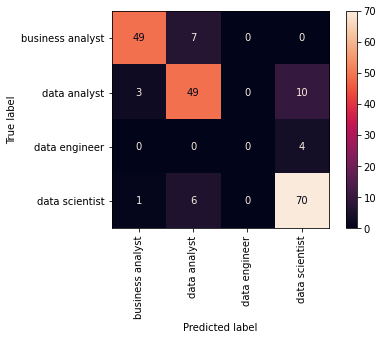

In [15]:
plot_confusion_matrix(clf_nb, X_test, y_test, values_format='d', xticks_rotation='vertical', cmap='rocket');

This result looks disturbingly good
- Have I overfitted?
- Have I made an error?  Is the model classifying the jobs that well? (80%)

Should now do some side-by-side analysis of the results

In [215]:

def evaluate_clf(clf, X_train, y_train, X_test, y_test, name='Model 1'):
    '''Convenience function for generating metrics
    - clf: sklearn classifier object
    - X:   X for full dataset (before train_test_split)
    - y:   y for full dataset (before train_test_split)'''
        
    # As a diagnostic, print the class imbalance ratios in training set
    unbalanced_ratio = list(y_train.value_counts())

    # Set up axes
    fig = plt.figure()
    fig.set_size_inches(10,5)
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_title(name)
    
    # Train for both the unbalanced dataset
    clf.fit(X_train, y_train);
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_cv = cross_val_score(clf, X_train, y_train)
    metrics = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)
    plot_confusion_matrix(clf, X_test, y_test, values_format='d', xticks_rotation='vertical', 
                          cmap='rocket', ax=ax1, colorbar=False);
    
    # Store results in a "results" dict
    results = dict()
    results['name'] = name
    results['class_ratio'] = unbalanced_ratio
    results['accuracy'] = accuracy
    results['accuracy_cv'] = accuracy_cv
    results['precision'] = metrics[0]
    results['recall'] = metrics[1]
    results['f1'] = metrics[2]
    
    return results

# Create fresh data frame for tracking
results = pd.DataFrame(columns=['name', 'class_ratio', 'accuracy', 'precision', 'recall', 'f1'])

def append_result(results, result):
    if result['name'] not in results.name.tolist():
        print('Result appended')
    else:
        print('Result appended, but name is a duplicate of existing row')
    results = results.append(result, ignore_index=True)
    return results


Result appended


,name,class_ratio,accuracy,precision,recall,f1
0,NaiveBayes (no re-balancing),"[275, 238, 237, 43]",0.844221,0.828845,0.844221,0.835704


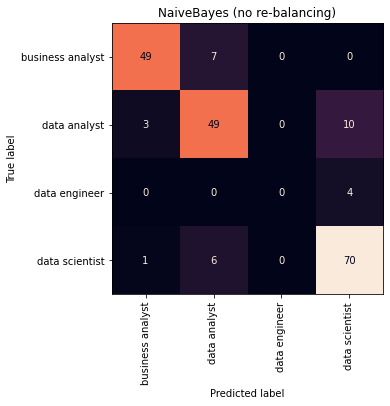

In [17]:
result = evaluate_clf(clf_nb, X_train, y_train, X_test, y_test, name='NaiveBayes (no re-balancing)', )

# Append to dataframe
results = append_result(results, result)
results

# Resampling using SMOTE

**But** we don't know whether it's helpful to "balance" the training data, so we need a copy of the model trained 

*NEED TO CHECK WHATs happening with the 

In [18]:
# Oversampling using SMOTE
from imblearn.over_sampling import SMOTE

oversample = SMOTE()

X_train_b, y_train_b = oversample.fit_resample(X_train, y_train)
y_train_b.value_counts()

data scientist      275
data engineer       275
business analyst    275
data analyst        275
Name: title_simplified, dtype: int64

In [19]:
# Copy the model and re-train it
from sklearn.base import clone

clf_nbr = clone(clf_nb)
clf_nbr.fit(X_train_b, y_train_b);

Result appended


,name,class_ratio,accuracy,precision,recall,f1
0,NaiveBayes (no re-balancing),"[275, 238, 237, 43]",0.844221,0.828845,0.844221,0.835704
1,NaiveBayes (rebalanced by SMOTE),"[275, 275, 275, 275]",0.849246,0.852831,0.849246,0.845847


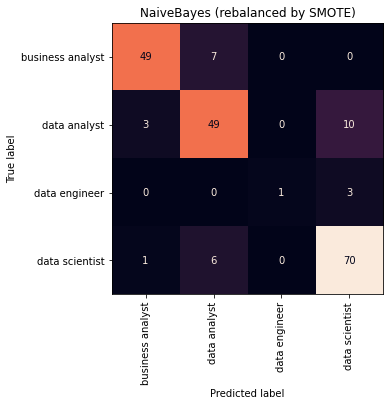

In [20]:
# Evaluate the resampled model
result = evaluate_clf(clf_nbr, X_train_b, y_train_b, X_test, y_test, name='NaiveBayes (rebalanced by SMOTE)')

# Append to dataframe
results = append_result(results, result)
results

# Examining most influential features 

In [22]:
# Get top 20 words in feature_log_prob_
def show_feature_probs(clf, vocab_list, n=10):
    for i, class_name in enumerate(clf_nb.classes_):
        # clf_nb.classes_[3]
        class_prob = clf_nb.feature_log_prob_[i].tolist()
        class_prob_sorted = [(x,y) for x,y in sorted(zip(vocab_list, class_prob), key=lambda pair: pair[1])]
        print(f'Top {n} highest probability tokens for "{class_name}":')
        print('<token>              <log_prob> <count in dataset>')
        features_to_print = class_prob_sorted[-n:]
        for i, feature in enumerate(features_to_print):
            print(f'{feature[0]:20} {feature[1]:.2f}      {str(word_counts_overall[feature[0]])}')
        print()
        
show_feature_probs(clf_nb, vocab_list, n=10)

Top 10 highest probability tokens for "business analyst":
<token>              <log_prob> <count in dataset>
ideaspassionate      -5.33      1
finisher             -5.24      1
angela               -5.20      3
insurance            -5.17      203
storiesproven        -5.05      1
nearly               -4.87      4
beloved              -4.82      1
bicycle              -4.79      2
landlords            -4.79      2
stay                 -3.77      49

Top 10 highest probability tokens for "data analyst":
<token>              <log_prob> <count in dataset>
activity             -5.51      64
ideaspassionate      -5.32      1
finisher             -5.26      1
angela               -5.22      3
beloved              -5.06      1
storiesproven        -4.98      1
bicycle              -4.94      2
landlords            -4.85      2
stay                 -4.75      49
therefore            -3.60      58

Top 10 highest probability tokens for "data engineer":
<token>              <log_prob> <count in d

In [25]:
# Assign X, y
X_tf, vocab_tf = nlp_vectorize_tf(df)

In [26]:
# train_test_split
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y, test_size=0.2, random_state=42)

What this shows is that for each class, the features with the highest probabilities of occurrance, are pretty much exclusively the ones that occur hardly ever in the dataset

# Try again using Tf-IDF
Should help to ignore tokens with low occurrance and high occurrance in the dataset.

In [23]:
# Write a new vectoriser
from sklearn.feature_extraction.text import TfidfVectorizer

def nlp_vectorize_tf(df, verbose=False):
    sent_list = nlp_pre_process(df, verbose=verbose)
    tfidf_vect = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy)
    X = tfidf_vect.fit_transform(sent_list)
    vocab_list = list(tfidf_vect.vocabulary_.keys())
    return X, vocab_list

In [24]:
nlp_vectorize_tf(df.head(2), verbose=True);

Tokenised:              ['join', 'us', 'data', 'scientist', 'identifying', 'working', 'large', 'complex', 'data', 'sets']...
Number of SENTENCES:    8
Number of UNIQUE WORDS: 222

Tokenised:              ['client', 'supports', 'international', 'organisations', 'pharmaceutical', 'healthcare', 'industries', 'across', 'range', 'bespoke']...
Number of SENTENCES:    4
Number of UNIQUE WORDS: 112



In [25]:
# Assign X, y
X_tf, vocab_tf = nlp_vectorize_tf(df)

In [26]:
# train_test_split
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y, test_size=0.2, random_state=42)

In [27]:
# Copy the model and re-train it
clf_nbtf = clone(clf_nb)
clf_nbtf.fit(X_train_tf, y_train_tf);

Result appended


,name,class_ratio,accuracy,precision,recall,f1
0,NaiveBayes (no re-balancing),"[275, 238, 237, 43]",0.844221,0.828845,0.844221,0.835704
1,NaiveBayes (rebalanced by SMOTE),"[275, 275, 275, 275]",0.849246,0.852831,0.849246,0.845847
2,NaiveBayes (with tfidf),"[275, 238, 237, 43]",0.748744,0.782786,0.748744,0.726976


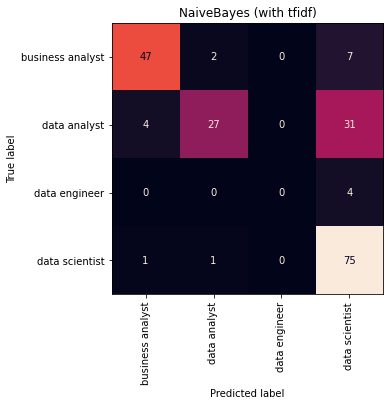

In [28]:
# Evaluate the resampled model
result = evaluate_clf(clf_nbtf, X_train_tf, y_train_tf, X_test_tf, y_test_tf, name='NaiveBayes (with tfidf)')

# Append to dataframe
results = append_result(results, result)
results

In [29]:
# Investigate feature probabilities
show_feature_probs(clf_nbtf, vocab_tf, n=10)

Top 10 highest probability tokens for "business analyst":
<token>              <log_prob> <count in dataset>
ideaspassionate      -5.33      1
finisher             -5.24      1
angela               -5.20      3
insurance            -5.17      203
storiesproven        -5.05      1
nearly               -4.87      4
beloved              -4.82      1
bicycle              -4.79      2
landlords            -4.79      2
stay                 -3.77      49

Top 10 highest probability tokens for "data analyst":
<token>              <log_prob> <count in dataset>
activity             -5.51      64
ideaspassionate      -5.32      1
finisher             -5.26      1
angela               -5.22      3
beloved              -5.06      1
storiesproven        -4.98      1
bicycle              -4.94      2
landlords            -4.85      2
stay                 -4.75      49
therefore            -3.60      58

Top 10 highest probability tokens for "data engineer":
<token>              <log_prob> <count in d

In [30]:
X_train_tf.shape

(793, 14392)

Looks like we have an issue with tfidf making no difference...

# Plotting utilities

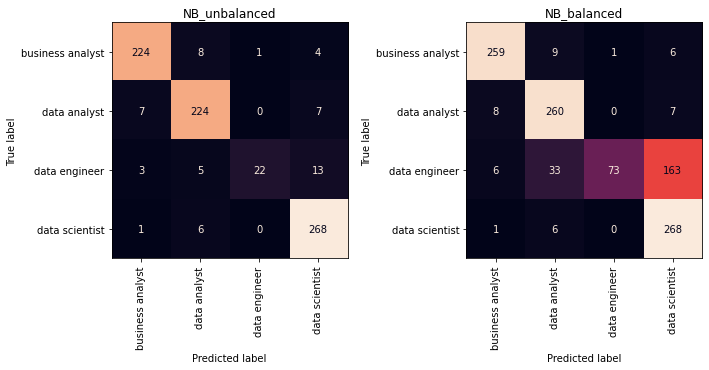

In [31]:
def compare_confusion(clf=None, X=None, y=None, name='Model 1',
                      clf2=None, X2=None, y2=None, name2='Model 2'):
    if any([a is None for a in [clf, clf2, X, X2, y, y2]]):
        raise ValueError('None values entered')
        
    # Set up axes
    fig = plt.figure()
    fig.set_size_inches(10,5)
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title(name)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title(name2)
    
    # Create plots
    plot_confusion_matrix(clf, X, y, values_format='d', xticks_rotation='vertical', 
                          cmap='rocket', ax=ax1, colorbar=False);
    plot_confusion_matrix(clf2, X2, y2, values_format='d', xticks_rotation='vertical', 
                          cmap='rocket', ax=ax2, colorbar=False);
    fig.tight_layout()
    
    
compare_confusion(clf_nb, X_train, y_train, 'NB_unbalanced',
                 clf_nb, X_train_b, y_train_b, 'NB_balanced')

Result appended


,name,class_ratio,accuracy,precision,recall,f1
0,NaiveBayes (no re-balancing),"[275, 238, 237, 43]",0.844221,0.828845,0.844221,0.835704
1,NaiveBayes (rebalanced by SMOTE),"[275, 275, 275, 275]",0.849246,0.852831,0.849246,0.845847
2,NaiveBayes (with tfidf),"[275, 238, 237, 43]",0.748744,0.782786,0.748744,0.726976
3,NaiveBayes (after rebalancing),"[275, 275, 275, 275]",0.849246,0.852831,0.849246,0.845847


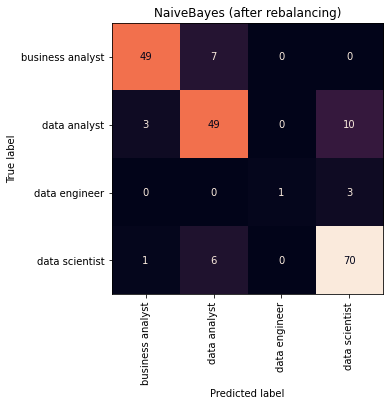

In [32]:
result = evaluate_clf(clf_nb, X_train_b, y_train_b, X_test, y_test, name='NaiveBayes (after rebalancing)')

# Append to dataframe
results = append_result(results, result)
results

*NEED TO CHECK ABOUT DATA LEAKAGE IF THE ROLE TITLE IS IN THE DESCRIPTION*?

# 2. Try with new preprocessing

Build fresh preprocessor and model

Usefulreference
- nltk.sent_tokenize
- nltk.word_tokenize

- nltk.ngrams
- nltk.everygrams

In [234]:
def lemmatize_sent(sent):
    lemmatizer = nltk.WordNetLemmatizer()
    sent_out = [lemmatizer.lemmatize(w) for w in sent]
    return sent_out

def nlp_pre_process_2(df, verbose=False):
    '''Takes the dataset as a df, extracts the "description" value and preprocesses:
    - sentence tokenize
    - word tokenize
    - remove stopwords
    - lemmatize each word
    - add n_grams'''
    stop_words = set(stopwords.words("english"))
    preprocessed_tokens = []
    
    for index, row in df.iterrows():        
        document = row.description.lower()      # Lower case the whole doc
        document = document.replace('\n',' ')   # Replace line breaks with spaces for tokenisation with weird formatting
        
        # Might eventually add n-grams in this loop.
        sents_list = nltk.sent_tokenize(document)                               # Sentence tokenise the document (into list of sentences)
        sents_list = [nltk.word_tokenize(sent) for sent in sents_list]          # Word tokenize each sentence
        sents_list = [remove_stopwords_doc(sent) for sent in sents_list]        # Remove stopwords from each sentence
        sents_list = [lemmatize_sent(sent) for sent in sents_list]              # Lemmatize each sentence
        ngrams_list = [nltk.ngrams(sent,2) for sent in sents_list]
        
        # Expand list of list, into one level list
        sent_expanded = [word for sent in sents_list for word in sent]          # [item for sublist in sents_list for item in sublist]
        ngrams_expanded = [gram for sent in ngrams_list for gram in sent]       # Same for ngrams_list
        ngrams_expanded = [' '.join(gram) for gram in ngrams_expanded]          # Convert ngram tuple to string
        tokens = sent_expanded + ngrams_expanded                                # Join into one long list
        
        if verbose: print(f'Raw text:                {document[:40]}...\n',
                          f'                         ...{document[-40:]}')
        if verbose: print(f'Tokenised:               {tokens[:5]}...\n'
                          f'                         ...{tokens[-5:]}')
        if verbose: print(f'Number of tokens:        {len(tokens)}')       
        if verbose: print(f'Number of UNIQUE tokens: {len(set(tokens))}\n')
                
        preprocessed_tokens.append(tokens)
                        
    return preprocessed_tokens

def nlp_vectorize_tf_2(df, max_df=1, min_df=1, max_features=None, verbose=False):
    preprocessed_tokens = nlp_pre_process_2(df, verbose=False)
    tfidf_vect = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy, 
                                 max_df=max_df, 
                                 min_df=min_df, 
                                 max_features=max_features)
    X = tfidf_vect.fit_transform(preprocessed_tokens)
    vocab_list = list(tfidf_vect.vocabulary_.keys())
    
    if verbose: 
        min_df_ = 0 if min_df==1 else min_df
        max_features_ = f'Only for top {max_features} features ordered by term frequency' if max_features is not None else 'For all features.'
        print(f'Vectorising only for tokens with document frequency between {min_df_*100:.1f}% to {max_df*100:.1f}%.\n' + max_features_)
        print(f'X, num rows:    {X.shape[0]}')
        print(f'X, num cols:    {X.shape[1]}')
        print(f'Col names:      {vocab_list[:5]}...\n'
              f'                ...{vocab_list[-5:]}')
    return X, vocab_list

In [190]:
nlp_pre_process_2(df.head(2), True);

Raw text:                join us as a data scientist you’ll be id...
                          ... and we’ll do everything we can to help.
Tokenised:               ['join', 'u', 'data', 'scientist', 'identifying']...
                         ...['scheme please', 'please contact', 'contact u', 'u everything', 'everything help']
Number of tokens:        628
Number of UNIQUE tokens: 514

Raw text:                my client supports international organis...
                          ...on:master's (preferred)work remotely:yes
Tokenised:               ['client', 'support', 'international', 'organisation', 'pharmaceutical']...
                         ...['education master', 'master preferred', 'preferred work', 'work remotely', 'remotely yes']
Number of tokens:        242
Number of UNIQUE tokens: 229



In [191]:
doc_vectorized, v = nlp_vectorize_tf_2(df.head(2), verbose=True)

Vectorising only for tokens with document frequency between 0.0% to 100.0%.
For all features.
X, num rows:    2
X, num cols:    691
Col names:      ['join', 'u', 'scientist', 'identifying', 'complex']...
                ...['education master', 'master preferred', 'preferred work', 'work remotely', 'remotely yes']


## Train a model

In [174]:
# Assign X, y
X_tf, vocab_tf = nlp_vectorize_tf_2(df, verbose=True)

X, num rows:    992
X, num cols:    535
Col names:      ['join', 'u', 'scientist', 'identifying', 'large']...
                ...['workshop', 'analyst join', 'top', 'team member', 'scope']


In [168]:
# train_test_split
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y, test_size=0.2, random_state=42)

In [169]:
# Copy the model and re-train it
clf_nbtf = clone(clf_nb)
clf_nbtf.fit(X_train_tf, y_train_tf);

Result appended, but name is a duplicate of existing row


,name,class_ratio,accuracy,precision,recall,f1
0,NaiveBayes (no re-balancing),"[275, 238, 237, 43]",0.844221,0.828845,0.844221,0.835704
1,NaiveBayes (rebalanced by SMOTE),"[275, 275, 275, 275]",0.849246,0.852831,0.849246,0.845847
2,NaiveBayes (with tfidf),"[275, 238, 237, 43]",0.748744,0.782786,0.748744,0.726976
3,NaiveBayes (after rebalancing),"[275, 275, 275, 275]",0.849246,0.852831,0.849246,0.845847
4,NaiveBayes (with tfidf),"[275, 238, 237, 43]",0.748744,0.782786,0.748744,0.726976
5,NaiveBayes (with tfidf),"[275, 238, 237, 43]",0.723618,0.794010,0.723618,0.690371
6,"NaiveBayes (with tfidf, new preprocessor)","[275, 238, 237, 43]",0.723618,0.794010,0.723618,0.690371
7,"NaiveBayes (with tfidf, new preprocessor)","[275, 238, 237, 43]",0.869347,0.852750,0.869347,0.860605


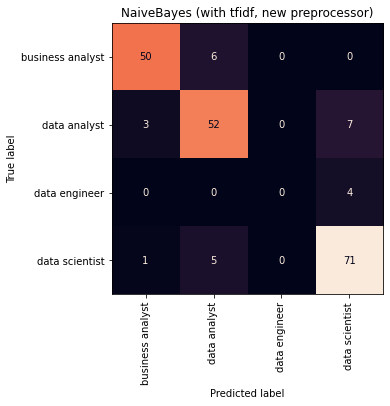

In [170]:
# Evaluate the resampled model
result = evaluate_clf(clf_nbtf, X_train_tf, y_train_tf, X_test_tf, y_test_tf, name='NaiveBayes (with tfidf, new preprocessor)')

# Append to dataframe
results = append_result(results, result)
results

In [171]:
# Get top 20 words in feature_log_prob_
def show_feature_probs_2(clf, vocab_list, X, n=10):
    for i, class_name in enumerate(clf_nb.classes_):
        # clf_nb.classes_[3]
        class_prob = clf_nb.feature_log_prob_[i].tolist()
        class_prob_sorted = [(x,y) for x,y in sorted(zip(vocab_list, class_prob), key=lambda pair: pair[1])]
        print(f'Top {n} highest probability tokens for "{class_name}":')
        print('<log_prob> <TFIDF_sum> <feature>')
        features_to_print = class_prob_sorted[-n:]
        for i, feature in enumerate(features_to_print):
            colnum = vocab_list.index(feature[0])
            print(f'{feature[1]:.2f}      {X[:,colnum].sum():.2f}        {feature[0]:30} ')
        print()
        
show_feature_probs_2(clf_nbtf, vocab_tf, X_train_tf, n=10)

Top 10 highest probability tokens for "business analyst":
<log_prob> <TFIDF_sum> <feature>
-7.07      18.40        lead                           
-7.05      11.58        monday                         
-6.97      26.43        asset                          
-6.38      10.02        exciting                       
-6.31      10.77        deliver                        
-6.06      13.10        gender                         
-5.83      7.63        master                         
-5.48      10.16        method                         
-5.34      18.95        workshop                       
-5.11      7.73        business requirement           

Top 10 highest probability tokens for "data analyst":
<log_prob> <TFIDF_sum> <feature>
-7.22      12.06        digital                        
-7.13      7.96        translate                      
-7.08      26.43        asset                          
-7.05      12.62        value                          
-6.43      10.02        exciting        

## Run again with all data, not just the subset of jobs

In [193]:
df = pd.read_csv('df_preprocessed.csv', index_col=0)
print(f'Data read from .csv\n>> ({len(df)} rows, {len(df.columns)} columns)\n')

Data read from .csv
>> (2422 rows, 58 columns)



In [ ]:
# Assign X, y
X_tf, vocab_tf = nlp_vectorize_tf_2(df, min_df=0.1, max_df=0.8, max_features=500, verbose=True)
y = df.title_simplified

In [223]:
# train_test_split
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y, test_size=0.2, random_state=42)

In [224]:
# Copy the model and re-train it
clf_nbtf = clone(clf_nb)
clf_nbtf.fit(X_train_tf, y_train_tf);

Result appended, but name is a duplicate of existing row


,name,class_ratio,accuracy,precision,recall,f1,accuracy_cv
0,"NaiveBayes (with tfidf, full dataset)","[528, 277, 239, 232, 144, 122, 108, 84, 54, 45...",0.472165,0.408330,0.472165,0.397087,"[0.4845360824742268, 0.49226804123711343, 0.48..."
1,"NaiveBayes (with tfidf, full dataset)","[528, 277, 239, 232, 144, 122, 108, 84, 54, 45...",0.472165,0.408330,0.472165,0.397087,"[0.4845360824742268, 0.49226804123711343, 0.48..."
2,"NaiveBayes (with tfidf, full dataset)","[528, 277, 239, 232, 144, 122, 108, 84, 54, 45...",0.536082,0.499493,0.536082,0.463012,"[0.5438144329896907, 0.5335051546391752, 0.540..."


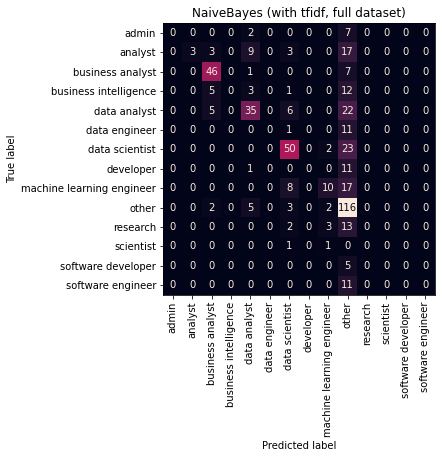

In [225]:
# Evaluate the resampled model
result = evaluate_clf(clf_nbtf, X_train_tf, y_train_tf, X_test_tf, y_test_tf, name='NaiveBayes (with tfidf, full dataset)')

# Append to dataframe
results = append_result(results, result)
results

In [228]:
# Get top 20 words in feature_log_prob_
def show_feature_probs_2(clf, vocab_list, X, n=10):
    for i, class_name in enumerate(clf_nb.classes_):
        # clf_nb.classes_[3]
        class_prob = clf_nb.feature_log_prob_[i].tolist()
        class_prob_sorted = [(x,y) for x,y in sorted(zip(vocab_list, class_prob), key=lambda pair: pair[1])]
        print(f'Top {n} highest probability tokens for "{class_name}":')
        print('<log_prob> <TFIDF_sum> <feature>')
        features_to_print = class_prob_sorted[-n:]
        for i, feature in enumerate(features_to_print):
            colnum = vocab_list.index(feature[0])
            print(f'{feature[1]:.2f}      {X[:,colnum].sum():.2f}        {feature[0]:30} ')
        print()
        
show_feature_probs_2(clf_nbtf, vocab_tf, X_train_tf, n=10)

Top 10 highest probability tokens for "business analyst":
<log_prob> <TFIDF_sum> <feature>
-7.70      21.41        every                          
-7.35      28.62        disability                     
-7.34      46.39        need                           
-7.07      46.38        effectively                    
-7.05      16.69        r                              
-6.38      84.23        aws                            
-6.31      76.74        identify                       
-6.06      27.19        quality                        
-5.83      32.92        place                          
-5.48      53.91        analytical                     

Top 10 highest probability tokens for "data analyst":
<log_prob> <TFIDF_sum> <feature>
-7.66      16.69        r                              
-7.36      28.62        disability                     
-7.28      27.19        quality                        
-7.23      36.02        communication                  
-7.22      51.71        month        

# Construct as an sklearn transformer and pipeline

In [301]:
# Define the custom transformer class
from sklearn.base import BaseEstimator, TransformerMixin

def nlp_preprocess_doc(doc, words_to_remove=set(), verbose=False):
    '''For each doc:
    - sentence tokenize
    - word tokenize
    - remove stopwords
    - lemmatize each word
    - add n_grams'''
    
    # Tidy up doc
    doc = doc.lower()               # Lower case the whole doc
    doc = doc.replace('\n',' ')     # Replace line breaks with spaces for tokenisation with weird formatting
    
    # Might eventually add n-grams in this loop.
    sents_list = nltk.sent_tokenize(doc)                               # Sentence tokenise the document (into list of sentences)
    sents_list = [nltk.word_tokenize(sent) for sent in sents_list]          # Word tokenize each sentence
    sents_list = [remove_stopwords_doc(sent) for sent in sents_list]        # Remove stopwords from each sentence
    sents_list = [lemmatize_sent(sent) for sent in sents_list]              # Lemmatize each sentence
    sents_list = [[w for w in sent if w not in words_to_remove] for sent in sents_list]
    ngrams_list = [nltk.ngrams(sent,2) for sent in sents_list]
    
    # Flatten in to a single list of tokens, for vectorization
    sent_expanded = [word for sent in sents_list for word in sent]          # [item for sublist in sents_list for item in sublist]
    ngrams_expanded = [gram for sent in ngrams_list for gram in sent]       # Same for ngrams_list
    ngrams_expanded = [' '.join(gram) for gram in ngrams_expanded]          # Convert ngram tuple to string
    tokens = sent_expanded + ngrams_expanded                                # Join into one long list
    
    if verbose: print(f'Raw text:                {document[:40]}...\n',
                        f'                         ...{document[-40:]}')
    if verbose: print(f'Tokenised:               {tokens[:5]}...\n'
                        f'                         ...{tokens[-5:]}')
    if verbose: print(f'Number of tokens:        {len(tokens)}')       
    if verbose: print(f'Number of UNIQUE tokens: {len(set(tokens))}\n')
    return tokens

def text_vectorize(X, max_df=1, min_df=1, max_features=None, words_to_remove=set(), verbose=False):
    preprocessed_tokens = []
    for doc in X:        
        tokens = nlp_preprocess_doc(doc, words_to_remove=words_to_remove, verbose=verbose)
        preprocessed_tokens.append(tokens)
    
    tfidf_vect = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy, 
                                 max_df=max_df, 
                                 min_df=min_df, 
                                 max_features=max_features)
    X = tfidf_vect.fit_transform(preprocessed_tokens)
    vocab_list = list(tfidf_vect.vocabulary_.keys())
    
    if verbose: 
        min_df_ = 0 if min_df==1 else min_df
        max_features_ = f'Only for top {max_features} features ordered by term frequency' if max_features is not None else 'For all features.'
        print(f'Vectorising only for tokens with document frequency between {min_df_*100:.1f}% to {max_df*100:.1f}%.\n' + max_features_)
        print(f'X, num rows:    {X.shape[0]}')
        print(f'X, num cols:    {X.shape[1]}')
        print(f'Col names:      {vocab_list[:5]}...\n'
              f'                ...{vocab_list[-5:]}')
    return X, vocab_list

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, max_df=1, min_df=1, max_features=None, words_to_remove=set()): # no *args or **kargs
        self.max_df = max_df
        self.min_df = min_df
        self.max_features = max_features
        self.words_to_remove = words_to_remove
        
    def fit(self, X, y=None): # the fit method does nothing
        return self  
    
    def transform(self, X): # the transform method adds 2 columns, and optionally bedrooms_per_room
        text_vectorised, self.vocab_list = text_vectorize(X, max_df=self.max_df, 
                                                             min_df=self.min_df, 
                                                             max_features=self.max_features,
                                                             words_to_remove=words_to_remove,
                                                             verbose=False)
        return text_vectorised

In [298]:
# Remove job titles from descriptions (as it's not fair if the job title is blatantly mentioned)
job_titles = list(df.title_simplified.unique())
words_to_remove = [nltk.word_tokenize(w) for w in job_titles] # list of lists
words_to_remove = [item for sublist in words_to_remove for item in sublist] # Flattened list of words
words_to_remove = lemmatize_sent(words_to_remove)
words_to_remove = set(words_to_remove)
words_to_remove

{'admin',
 'analyst',
 'business',
 'data',
 'developer',
 'engineer',
 'intelligence',
 'learning',
 'machine',
 'other',
 'research',
 'scientist',
 'software'}

Result appended
                                             name  \
0           NaiveBayes (with tfidf, full dataset)   
1           NaiveBayes (with tfidf, full dataset)   
2           NaiveBayes (with tfidf, full dataset)   
3        NaiveBayes (with tfidf, pipeline version   
4        NaiveBayes (with tfidf, pipeline version   
5        NaiveBayes (with tfidf, pipeline version   
6        NaiveBayes (with tfidf, pipeline version   
7        NaiveBayes (with tfidf, pipeline version   
8        NaiveBayes (with tfidf, pipeline version   
9        NaiveBayes (with tfidf, pipeline version   
10       NaiveBayes (with tfidf, pipeline version   
11       NaiveBayes (with tfidf, pipeline version   
12                          NB model - min_df=0.4   
13                          NB model - min_df=0.5   
14      NB model (min_df:{text_prep.self.min_df})   
15  NB model (min_df:0.7, max_df:0.9, max_f:None)   
16  NB model (min_df:0.1, max_df:0.8, max_f:None)   
17  NB model (min_df:0.1, max_

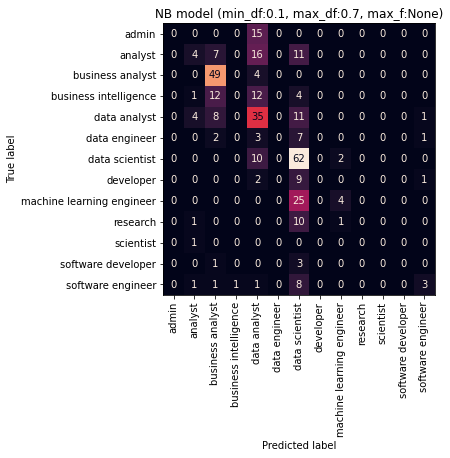

In [331]:
# Prep up X and y for training model
text_prep = TextPreprocessor(max_df=0.7, min_df=0.1, max_features=None, words_to_remove=words_to_remove)
this_df = df.drop(df[df.title_simplified == 'other'].index, axis=0)
X = this_df.description
X = text_prep.fit_transform(X)
y = this_df.title_simplified

# Split to train and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_nb = MultinomialNB()
clf_nb.fit(X_train, y_train);

# Evaluate the resampled model
result = evaluate_clf(clf_nb, X_train, y_train, X_test, y_test, name=f'NB model (min_df:{text_prep.min_df}, max_df:{text_prep.max_df}, max_f:{text_prep.max_features})')

show_feature_probs_2(clf_nb, text_prep.vocab_list, X_train, n=5)

# Append to dataframe
results = append_result(results, result)
print(results)